# Main notebook

Install all requirements and connect to drive

In [1]:
!pip install pygame
from google.colab import drive
drive.mount('/content/gdrive')
%cd gdrive/MyDrive/TrainsWithBrains

     |████████████████████████████████| 21.8 MB 1.1 MB/s 
Mounted at /content/gdrive
/content/gdrive/MyDrive/TrainsWithBrains


### Set up the evn

In [5]:
from train import Train
from railway import Railway
from subwaysystem import SubwaySystem
import pandas as pd
import numpy as np
import random
from ddqp import DDQNAgent
import tensorflow as tf
from scipy.spatial.distance import pdist, squareform
import matplotlib.pyplot as plt

linje1coords = pd.read_csv("lines/linje1.csv", index_col=0)
linje2coords = pd.read_csv("lines/linje2.csv", index_col=0)
linje4coords = pd.read_csv("lines/linje4.csv", index_col=0)
linje5coords = pd.read_csv("lines/linje5.csv", index_col=0)
linje6coords = pd.read_csv("lines/linje6.csv", index_col=0)

linje2stops = pd.concat([linje2coords[linje2coords.index==4] ,linje2coords.sample()])
linje2stops[["stop_time", "active"]] = [[500,False],[300, False]]

linje4stops = pd.concat([linje4coords.sample()])
linje4stops[["stop_time", "active"]] = [[500,False]]


subwaysystem = SubwaySystem()

# Add all lines
linje1 = Railway(linje1coords)
linje2 = Railway(linje2coords, linje2stops)
linje4 = Railway(linje4coords, linje4stops, train_loop_strategy="line")
linje5 = Railway(linje5coords, train_loop_strategy="line")
linje6 = Railway(linje6coords, train_loop_strategy="line")

# Add all trains
linje1.add_train(Train())
linje2.add_train(Train(direction = 1, max_speed = 150))
linje2.add_train(Train(direction = -1))
linje4.add_train(Train())
linje5.add_train(Train())
linje6.add_train(Train())


# Add lines inn system
#subwaysystem.add_railway(linje1)
#subwaysystem.add_railway(linje2)
#subwaysystem.add_railway(linje4)
subwaysystem.add_railway(linje5)
subwaysystem.add_railway(linje6)


### Reinformant learning

In [3]:
#subwaysystem.find_intersections()
#subwaysystem.render()
#subwaysystem.run_simualation()
#subwaysystem.reset()


# ========
# Reinformant learning!
# ========

agent = DDQNAgent(alpha=0.005, gamma=0.99, n_actions=2, max_speed=100,
                  epsilon=1.0, batch_size=32, input_dims=8)
r_history = []

n_games = 1
done = False
max_interations = 3000


for i in range(n_games):
    score = 0
    o = 0
    state, done = subwaysystem.reset()
    
    actions = []
    states = []
    states_ = []
    rewards = []
    dones = []
    speeds = []
    distances = []
        
        # Do action on env
    while not done:
        o += 1
        action = agent.choose_action(state)
        state_, reward, done, info = subwaysystem.step(action)
        score += reward
        
        # Save things on the way
        rewards.append(reward)
        speeds.append([train.speed for train,_,_ in subwaysystem.trains])
        distances.append(pdist([train.position for train,_,_ in subwaysystem.trains]))
        
        agent.remeber(state, action, reward, state_, done)
        
        #if np.random.random() > 0.2:
        agent.learn()
        # Save all actions and hendelser
        #actions.append(action)
        #states.append(state)
        #states_.append(state_)
        #rewards.append(reward)
        #dones.append(done)
    
        state = state_
        
        #if o>100:
        #    break
        if o%100 == 0:
            print(o, [train.speed for train,_,_ in subwaysystem.trains])
            
        if o>max_interations:
            done = True
            print("stopper pga maxinteretatoion")
            
    
            
        

        # == Learn from action ==
        #agent.discount_reward()
        # agent.learn(tape)
        
        #r_history.append(score)
        

distances = np.array(distances)
speeds = np.array(speeds)


/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/adam.py:105: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


100 [5.9435273063129825, 6.115056559734959]
200 [12.148724232591105, 12.287885316484939]
300 [18.15957609844654, 18.054573748734043]
400 [24.069072577596536, 24.280900285051633]
500 [29.90545558493576, 30.475420049318767]
600 [35.99170724580715, 36.83688069670156]
700 [42.14067818226806, 42.88023109036928]
800 [48.13824461488666, 48.83395233811662]
900 [54.12150284394276, 54.520826729415084]
1000 [60.09939699886369, 60.28858542267956]
1100 [66.0298524361748, 66.58688555053648]
1200 [72.03020413552265, 72.31955315417969]
1300 [78.29891597926759, 78.49999739258652]
1400 [83.9612273749989, 84.77700294130625]
1500 [89.85178790283037, 91.00286528882647]
1600 [95.82029046450711, 96.93723740082794]
Kræsj


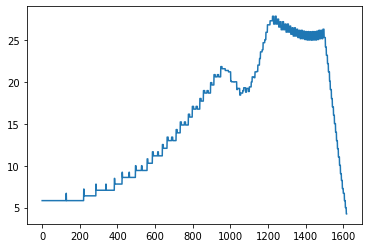

In [6]:
plt.plot(distances)

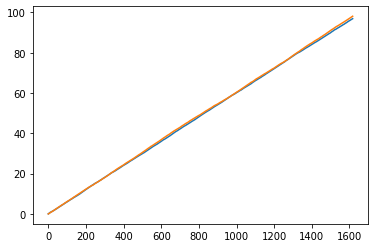

In [7]:
plt.plot(speeds)